In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 판다스 출력 결과를 소수점 둘째 자리 까지로 제한
pd.options.display.float_format = '{:,.2f}'.format
sales_df = pd.read_csv(r'C:\Users\user\Downloads\sales_data.csv', index_col=['customer_id'])
sales_df

,total_buy_cnt,total_price
customer_id,,
12395,99,430250
12427,98,566410
12431,122,849900
12433,625,1180950
12471,10,97750
...,...,...
18144,30,90750
18168,243,1533530
18225,1,91430


### sales_df 과 total_price 에 대한 scatterplot을 생성

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

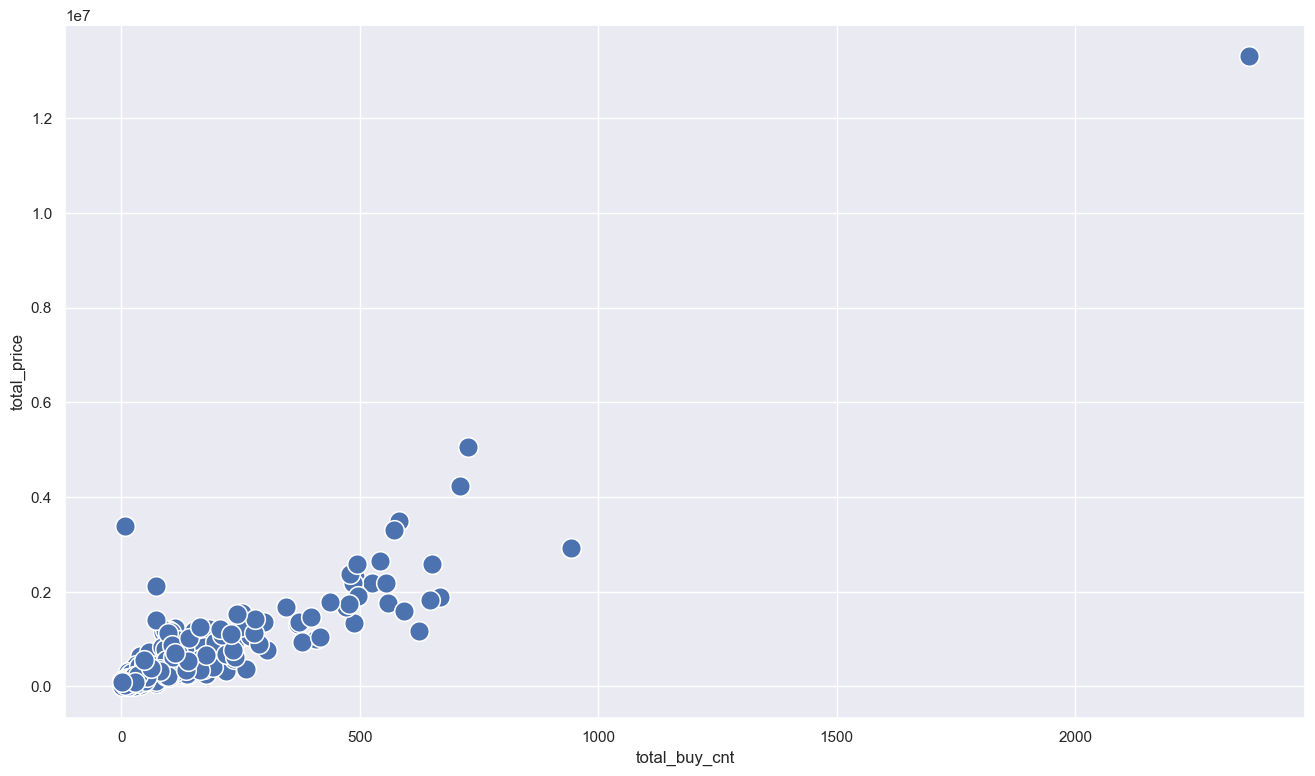

In [5]:
sns.set(style='darkgrid',
       rc={'figure.figsize':(16,9)})

sns.scatterplot(x=sales_df['total_buy_cnt'], y=sales_df['total_price'], s=200)

### 이상점 제거 : IQR 방법 사용

In [7]:
def get_outlier_mask(df, weight=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    
    IQR = Q3 - Q1
    IQR_weight = IQR * weight
    range_min = Q1 - IQR_weight
    range_max = Q3 + IQR_weight
    
    outlier_per_column = (df < range_min) | (df > range_max)
    
    is_outlier = outlier_per_column.any(axis=1)
    
    return is_outlier

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

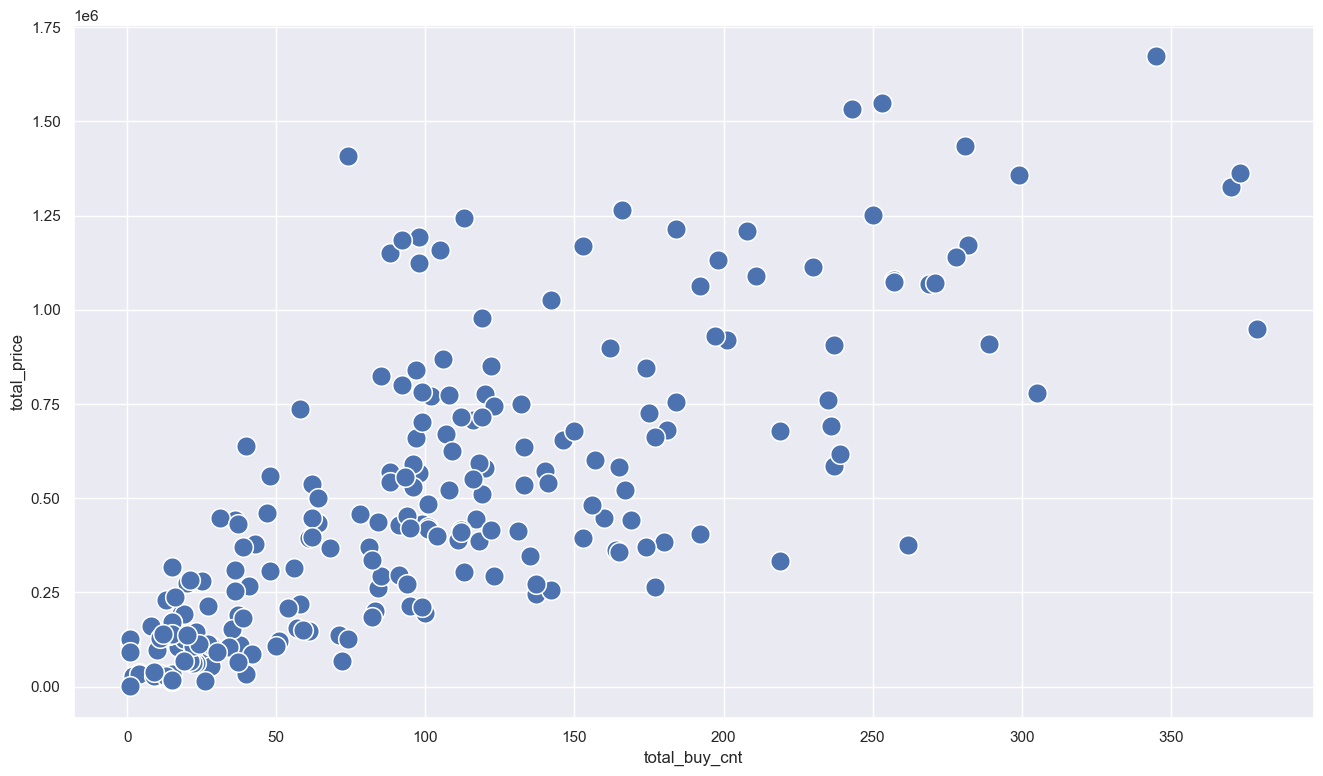

In [8]:
outlier_idx_cust_df = get_outlier_mask(sales_df, weight=1.5)

# 아웃라이어 제거한 데이터 프레임만 추가
sales_df = sales_df[~outlier_idx_cust_df]

# 아웃라이어 제거한 데이터프레임 시각화
sns.scatterplot(x=sales_df['total_buy_cnt'], y=sales_df['total_price'], s=200)

In [9]:
sales_df.describe()

,total_buy_cnt,total_price
count,225.00,225.00
mean,103.38,"487,954.40"
std,82.54,"380,912.52"
min,1.00,350.00
25%,36.00,"159,860.00"
50%,94.00,"412,920.00"
75%,142.00,"707,910.00"
max,379.00,"1,672,130.00"


In [10]:
df_mean = sales_df.mean()  # 각 컬럼의 평균값
df_std = sales_df.std()  # 각 컬럼의 표준편차

scaled_df = (sales_df - df_mean)/df_std  # 컬럼별 표준화 진행 

scaled_df.columns = ['total_buy_cnt', 'total_price']

# 인덱스 설정
scaled_df.index = sales_df.index 

scaled_df

,total_buy_cnt,total_price
customer_id,,
12395,-0.05,-0.15
12427,-0.07,0.21
12431,0.23,0.95
12471,-1.13,-1.02
12472,-0.19,0.21
...,...,...
18144,-0.89,-1.04
18168,1.69,2.74
18225,-1.24,-1.04


In [11]:
sales_df.mean()

total_buy_cnt       103.38
total_price     487,954.40
dtype: float64

In [12]:
sales_df.std()

total_buy_cnt        82.54
total_price     380,912.52
dtype: float64

# k-means 모델 학습

In [14]:
from sklearn.cluster import KMeans

In [15]:
# k-means(k=2)
model = KMeans(n_clusters=2, random_state=123)

### 오류메세지를 해결하기 위한 코드
> 1. Intel MKL(Math Kernel Library)이 사용되고 처리 중인 데이터 청크보다 사용 가능한 스레드가 더 많은 경우 'KMeans'가 Windows 시스템에서 메모리 누수를 일으킬 수 있는 알려진 문제를 경고
> 2. n_init에 대한 향후 경고  
: 코드가 미래에도 보장되며 업그레이드 시 기본 설정 변경으로 인해 영향을 받지 않기위해

In [17]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, n_init=10)

In [18]:
# 모델 학습
model.fit(scaled_df)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=2, random_state=123)

### 클러스터 시각화

##### 먼저, predict()를 활용해 각 데이터가 어떤 클러스터로 구분됐는지 표시합니다
##### 해당 값을 scaled_df에 새로운 열(label)로 추가

In [21]:
# label 컬럼 생성
scaled_df['label'] = model.predict(scaled_df)

scaled_df

,total_buy_cnt,total_price,label
customer_id,,,
12395,-0.05,-0.15,0
12427,-0.07,0.21,0
12431,0.23,0.95,1
12471,-1.13,-1.02,0
12472,-0.19,0.21,0
...,...,...,...
18144,-0.89,-1.04,0
18168,1.69,2.74,1
18225,-1.24,-1.04,0


##### 라벨링 된 데이터를 기준으로 클러스터를 구분해 시각화 해보고, 거기에 Centroid도 함께 표시해 보겠습니다  
(Centroid는 model.cluster_centers_로 값을 받아옵니다).

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

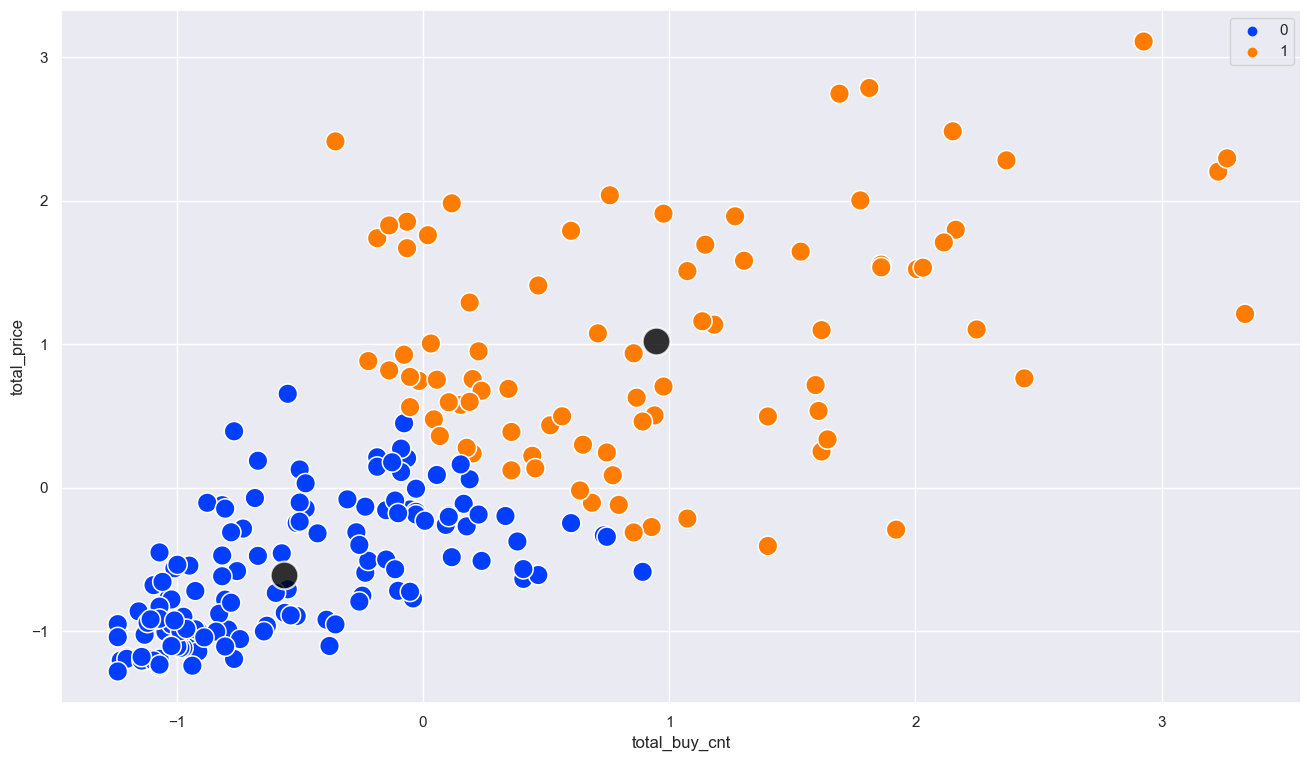

In [23]:
# 각 군집의 중심점
centers = model.cluster_centers_

sns.scatterplot(x=scaled_df['total_buy_cnt'], y=scaled_df['total_price'], hue=scaled_df['label'], s=200, palette='bright')
sns.scatterplot(x=centers[:,0], y=centers[:,1], color='black', alpha=0.8, s=400)


### 데이터의 inertia 확인

In [25]:
model.inertia_

187.06526917589164

### scaled_df에 추가했던 label 열을 제거

In [27]:
scaled_df = scaled_df.drop(['label'], axis=1)

## for문을 통해 k 값을 범위로 지정한 후, 각 inertia 값들을 리스트에 저장해 그래프를 그려 최적의 k 값을 도출하는 과정

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment v

<Axes: >

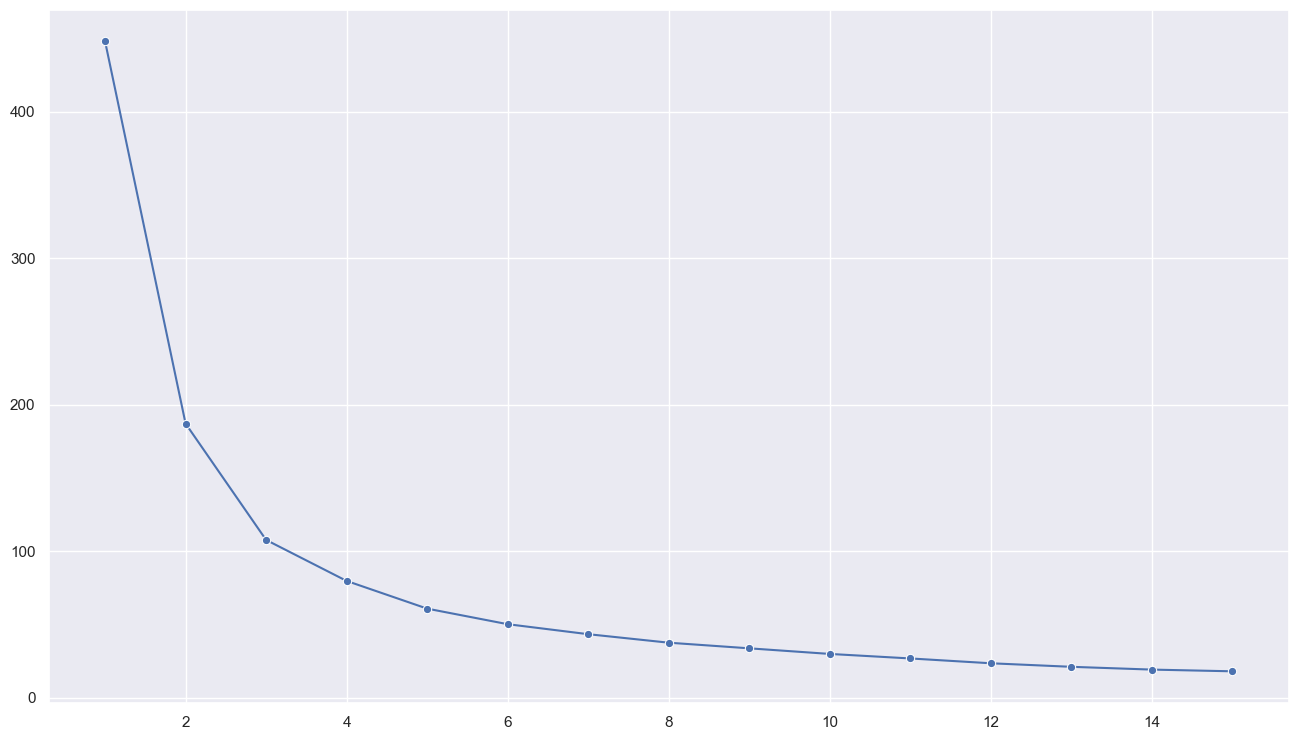

In [29]:
# inertia 값 저장할 리스트
inertias = []     

for k in range(1, 16): # k값의 범위 1~15로 지정
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(scaled_df)
    inertias.append(model.inertia_)

# k값에 따른 inertia값 시각화
sns.lineplot(x=range(1, 16), y=inertias, marker='o')

# k 값을 5로 지정하여 분석하기
> 1. predict함수를 사용하여, 'label'이라는 col을 생성하고 그 값을 저장한다
>> predict함수는 각 cluster별 그룹의 번호들을 보여주는 함수다.
> 2. sns.scatterplot을 통해 시각화하여 확인한다.
> 3. 각 그룹에 속하는 데이터의 양을 확인한다.
> 4. 각 그룹별 평균값을 새로운 col에 저장하여 확인한다. 

In [31]:
model = KMeans(n_clusters=5, random_state=123)
model.fit(scaled_df)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, random_state=123)

In [32]:
sales_df['label'] = model.predict(scaled_df)


C:\Users\user\AppData\Local\Temp\ipykernel_25636\2159738958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df['label'] = model.predict(scaled_df)


<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

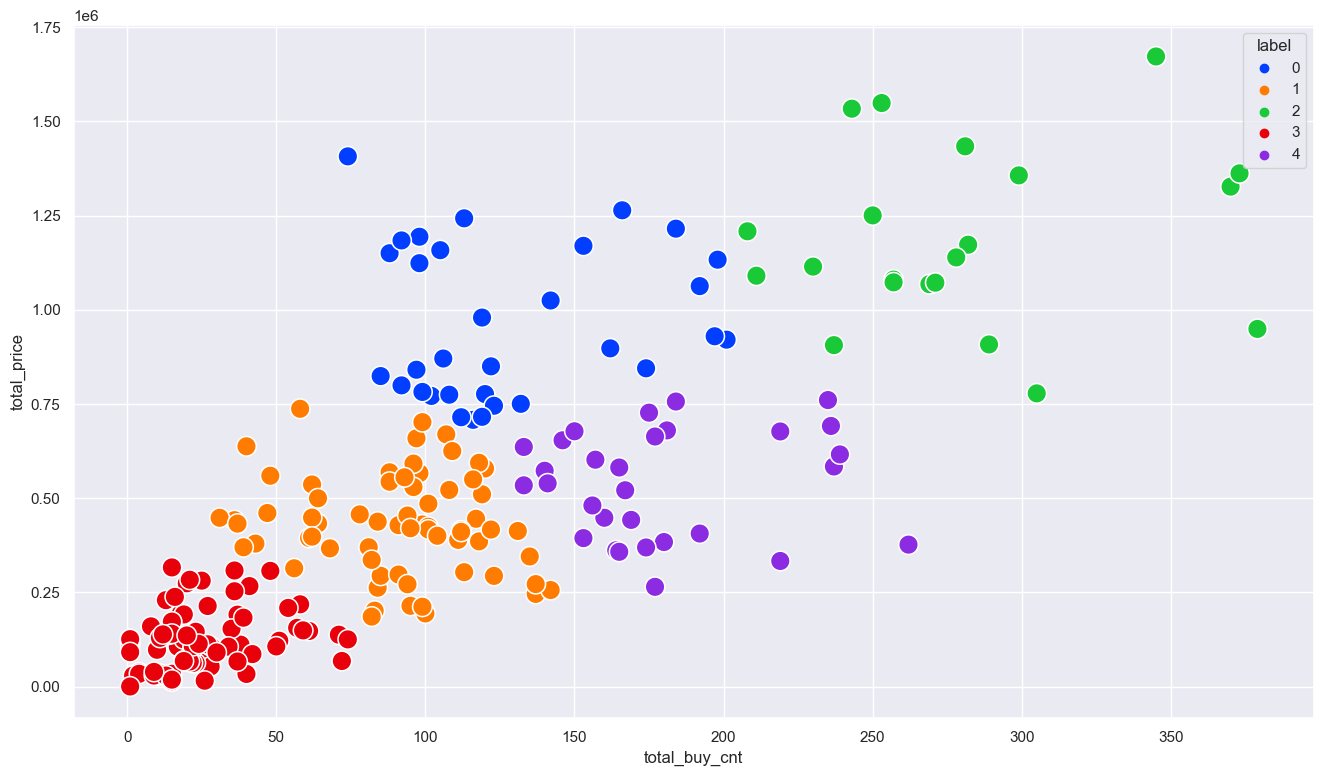

In [33]:
sns.scatterplot(x= sales_df['total_buy_cnt'], y= sales_df['total_price'], hue= sales_df['label'], s=200, palette='bright')

In [34]:
pd.DataFrame(sales_df['label'].value_counts())

,count
label,
3,76
1,66
0,32
4,30
2,21


In [35]:
groupby_df = sales_df.groupby('label').mean()

In [36]:
groupby_df['price_mean'] = groupby_df['total_price'] / groupby_df['total_buy_cnt']

In [37]:
groupby_df

,total_buy_cnt,total_price,price_mean
label,,,
0,127.78,"963,223.12","7,538.06"
1,90.36,"430,419.85","4,763.20"
2,280.33,"1,192,478.57","4,253.79"
3,25.46,"124,004.74","4,870.47"
4,179.53,"536,416.00","2,987.84"


# Dendrogram (계층적 클러스터)

In [39]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import matplotlib.pyplot as plt

In [40]:
# 거리 : ward method
model = linkage(scaled_df, 'ward')

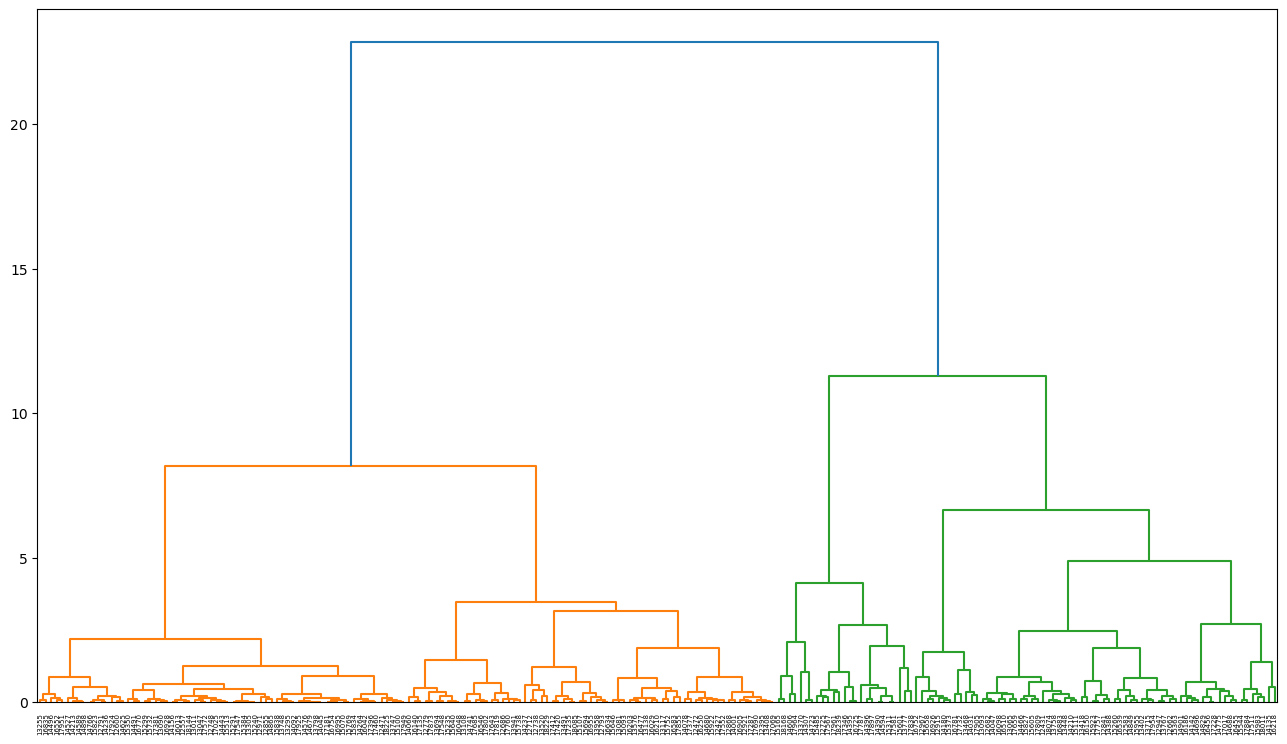

In [41]:
labelList = scaled_df.index 

# 덴드로그램 사이즈와 스타일 조정
plt.figure(figsize=(16,9))
plt.style.use("default")

dendrogram(model, labels=labelList)
plt.show()

In [42]:
cluster_num = 5

# 고객별 클러스터 라벨 구하기
scaled_df['label'] = cut_tree(model, cluster_num)

pd.DataFrame(scaled_df['label'].value_counts())

,count
label,
0,67
2,67
1,54
3,25
4,12


<Axes: xlabel='total_price', ylabel='total_buy_cnt'>

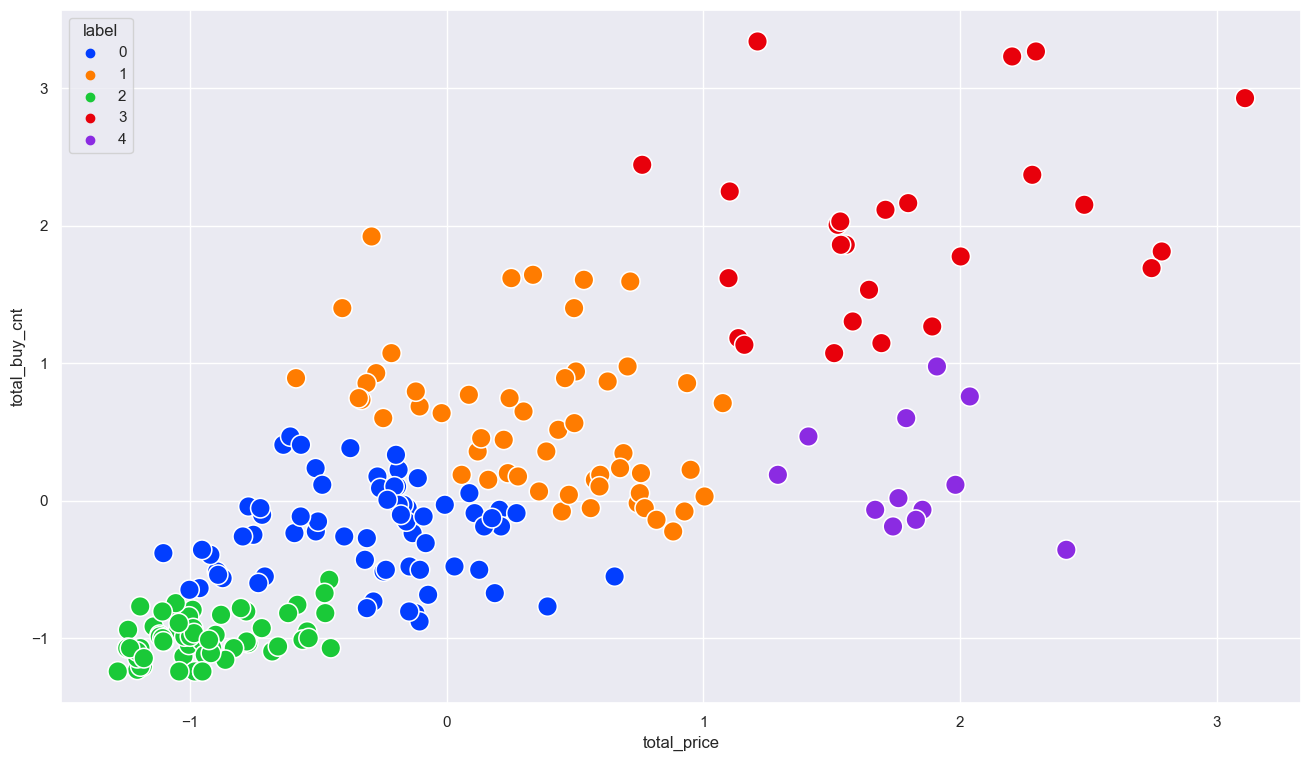

In [43]:
sns.set(style="darkgrid",
        rc = {'figure.figsize':(16,9)})

# 계층적 클러스터링
sns.scatterplot(x=scaled_df['total_price'], y=scaled_df['total_buy_cnt'], hue=scaled_df['label'], s=200, palette='bright')

#  DBSCAN

<Axes: xlabel='0', ylabel='1'>

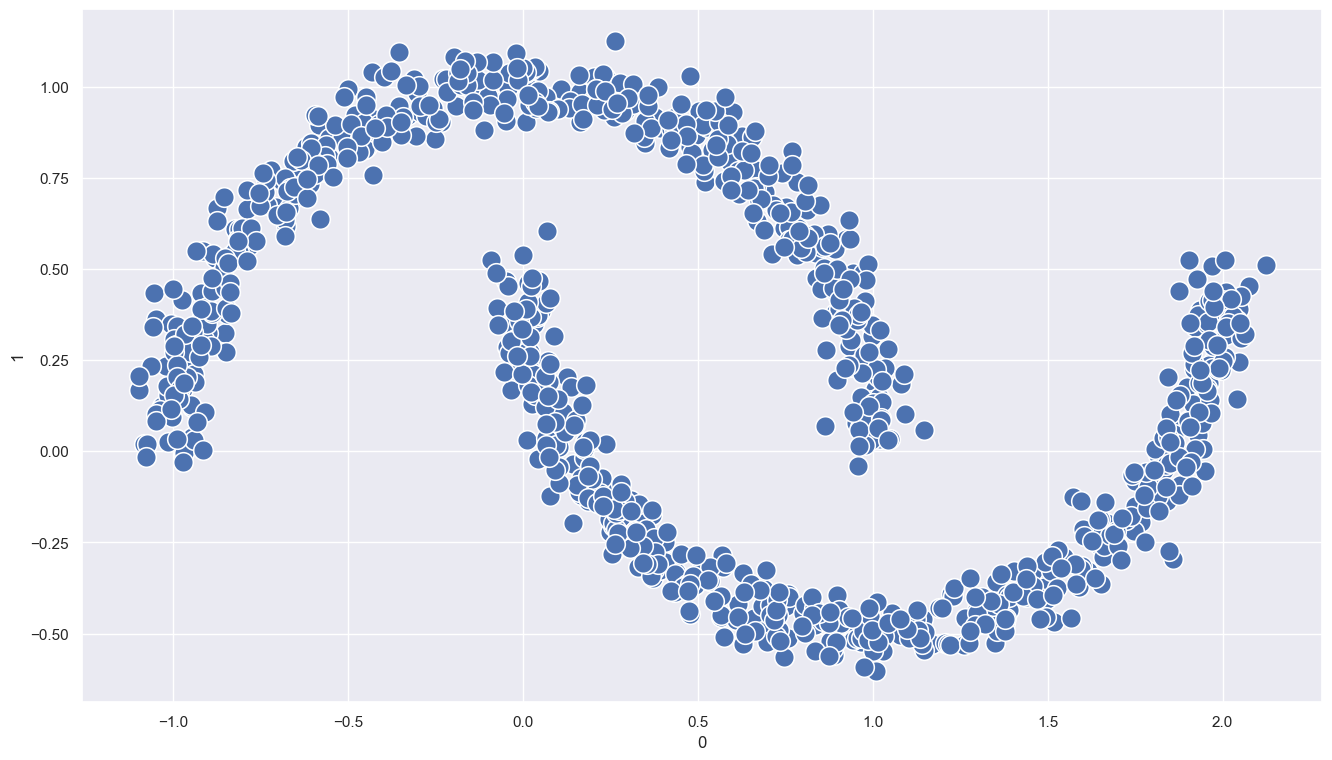

In [45]:
from sklearn.datasets import make_moons
import numpy as np

n_samples = 1000
np.random.seed(3)
X, y = make_moons(n_samples=n_samples, noise=.05)  # noise: 잡음의 크기. 0이면 정확한 반원을 이룸
df = pd.DataFrame(X)

#시각화
plt.figure(figsize=(16, 9))
sns.scatterplot(x=df[0], y=df[1], marker='o', s=200)


### k-means와 비교하기위해 위 데이터를 k-means로 분석

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

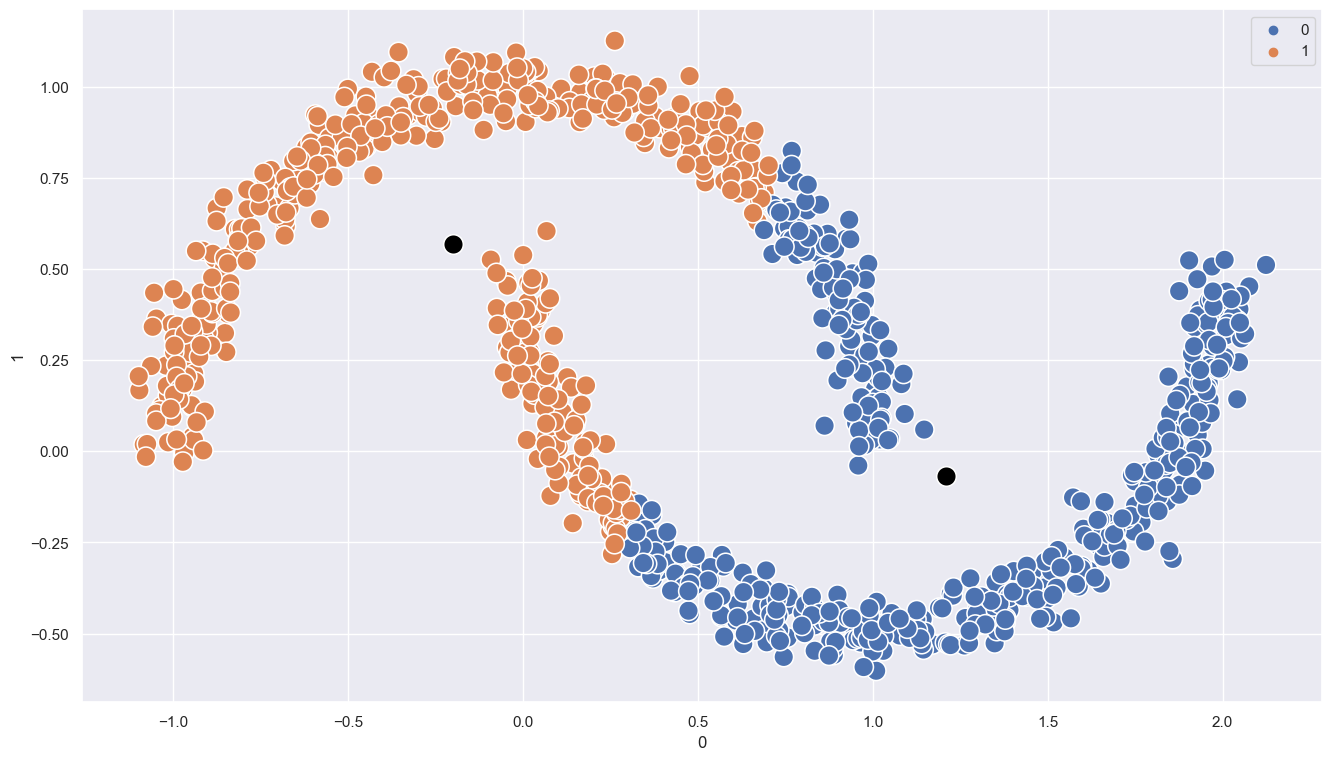

In [47]:
# k-means 모델 학습
model = KMeans(n_clusters=2, random_state = 123)
model.fit(df)

# 클러스터 라벨링
df['kmeans_label'] = model.predict(df)

# 각 군집의 중심점
centers = model.cluster_centers_

# 클러스터링 결과 시각화
plt.figure(figsize=(16, 9))

sns.scatterplot(x=df[0], y=df[1], hue=df['kmeans_label'] , s=200)
sns.scatterplot(x=centers[:,0], y=centers[:,1], color='black', s=200)


### k-means로 분석된 col 'kmeans_label' 삭제

In [49]:
df = df.drop(columns=['kmeans_label'], axis=1)

<Axes: xlabel='0', ylabel='1'>

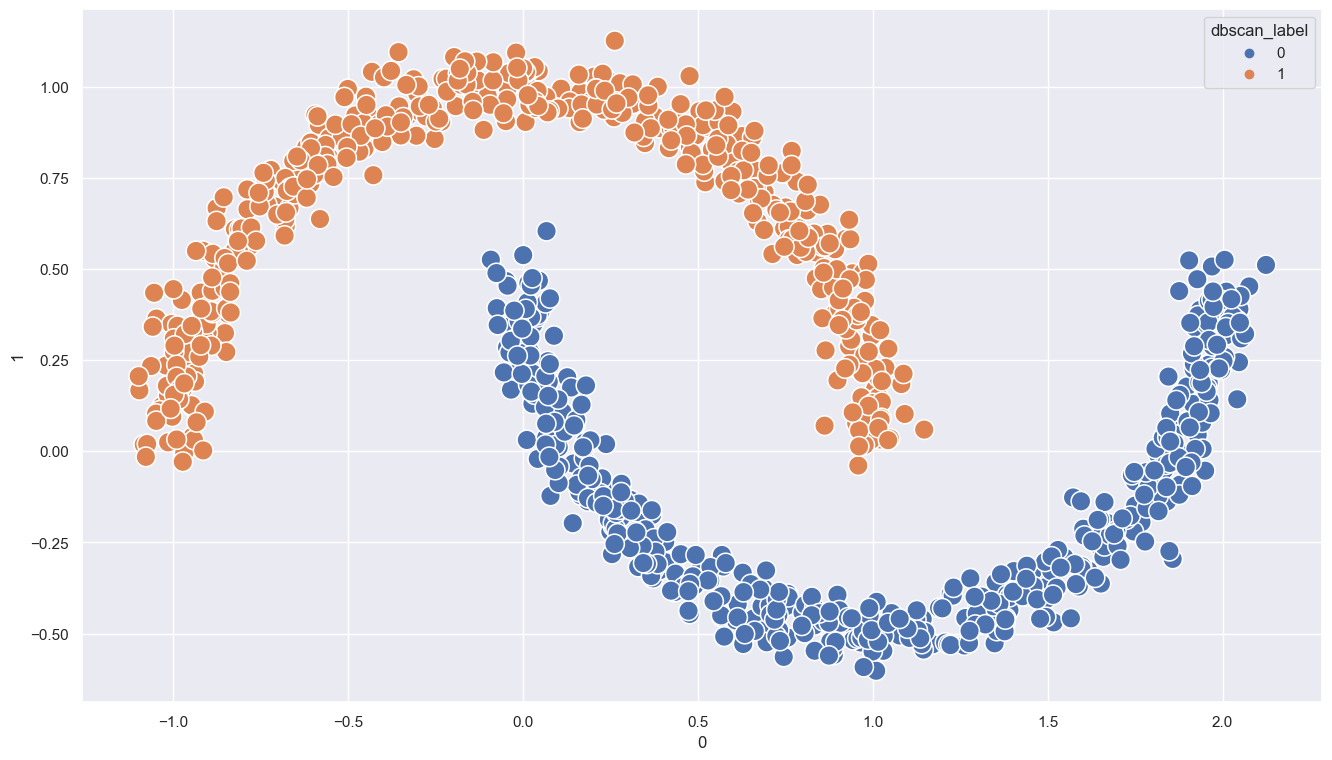

In [50]:
from sklearn.cluster import DBSCAN

eps = 0.1 # 반경
min_samples = 5 # 최소 데이터 갯수

# DBSCAN 모델 학습
model = DBSCAN(eps=eps, min_samples=min_samples)
model.fit(df)
df['dbscan_label'] = model.labels_

# 시각화
plt.figure(figsize=(16, 9))
sns.scatterplot(x=df[0], y=df[1], hue=df['dbscan_label'], s=200)


# GMM
> 데이터는 sklearn의 make_blobs()로 생성할 건데요. make_blobs()로 생성한 데이터에 특수 행렬을 곱해주면 타원형으로 길게 늘어진 데이터를 생성할 수 있습니다.

<Axes: xlabel='0', ylabel='1'>

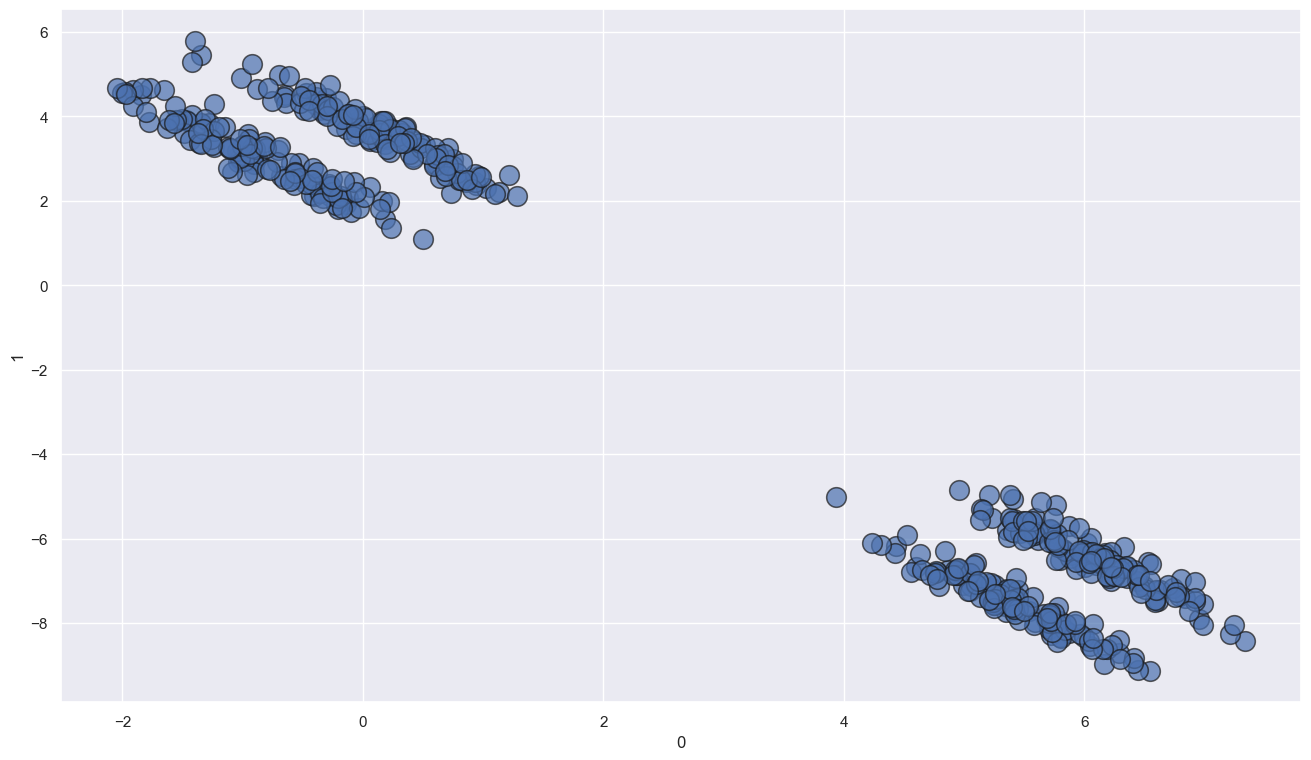

In [52]:
from sklearn.datasets import make_blobs

n_samples = 500   # 샘플 데이터 개수
centers = 4   # 클러스터 개수
cluster_std = 0.75   # 클러스터 내 표준편차
random_state = 13   # 샘플 데이터 고정
 
data, clusters = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)

# 데이터 타원형으로 만들기
tf = [[0.6, -0.6], [-0.4, 0.8]]
data_tf = data @ tf  # @ : 행렬의 곱을 나타냄
df = pd.DataFrame(data_tf)

# 시각화
sns.scatterplot(x=df[0], y=df[1], alpha = 0.7, edgecolor="k", s=200)

### k-means로 먼저 학습시키기

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

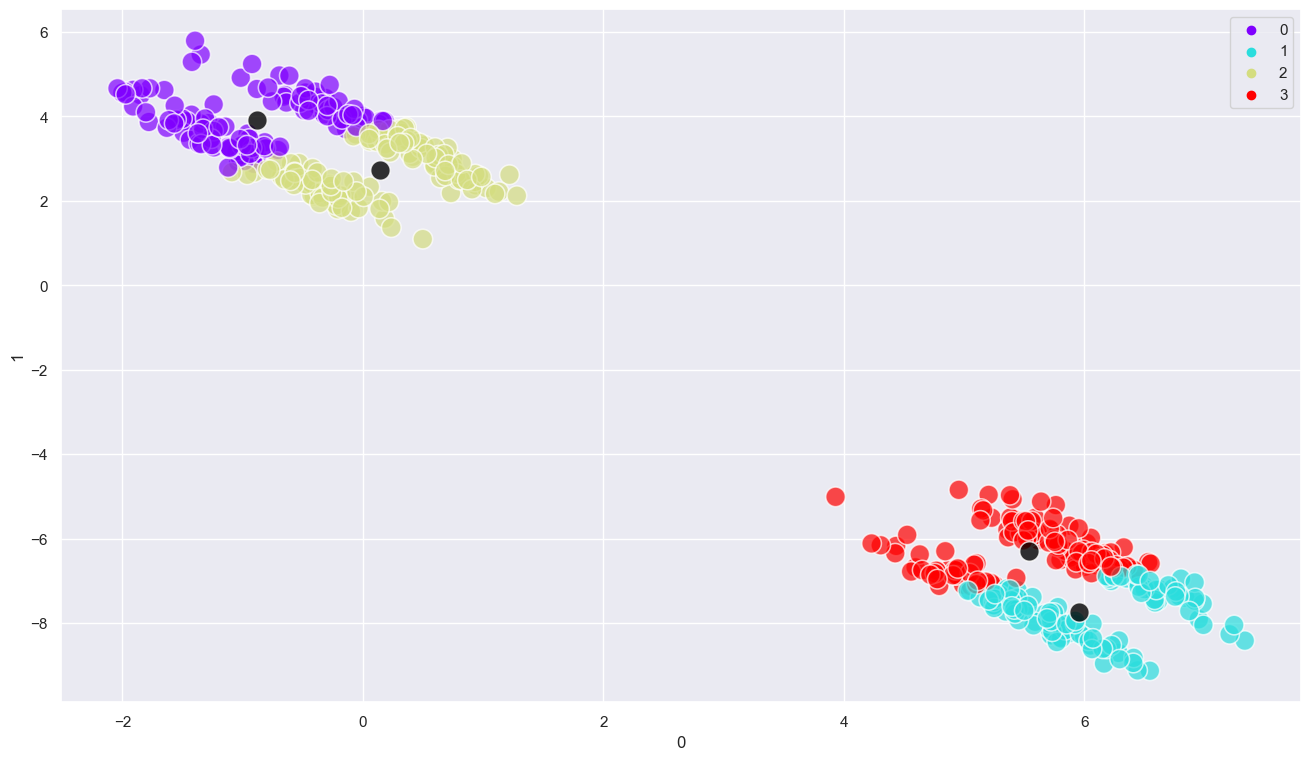

In [54]:
# k-means 학습
model = KMeans(n_clusters=4, random_state=123)
model.fit(df)
df['kmeans_label'] = model.predict(df)
centers = model.cluster_centers_ # 각 클러스터의 Centorid

# 시각화
sns.scatterplot(x=df[0], y=df[1], hue=df['kmeans_label'], palette='rainbow', alpha=0.7, s=200)
sns.scatterplot(x=centers[:,0], y=centers[:,1], color='black', alpha=0.8, s=200)

### df['kmeans_label']를 제거한 후에 GMM 모델을 학습시키기

In [56]:
df = df.drop(columns=['kmeans_label'], axis=1)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

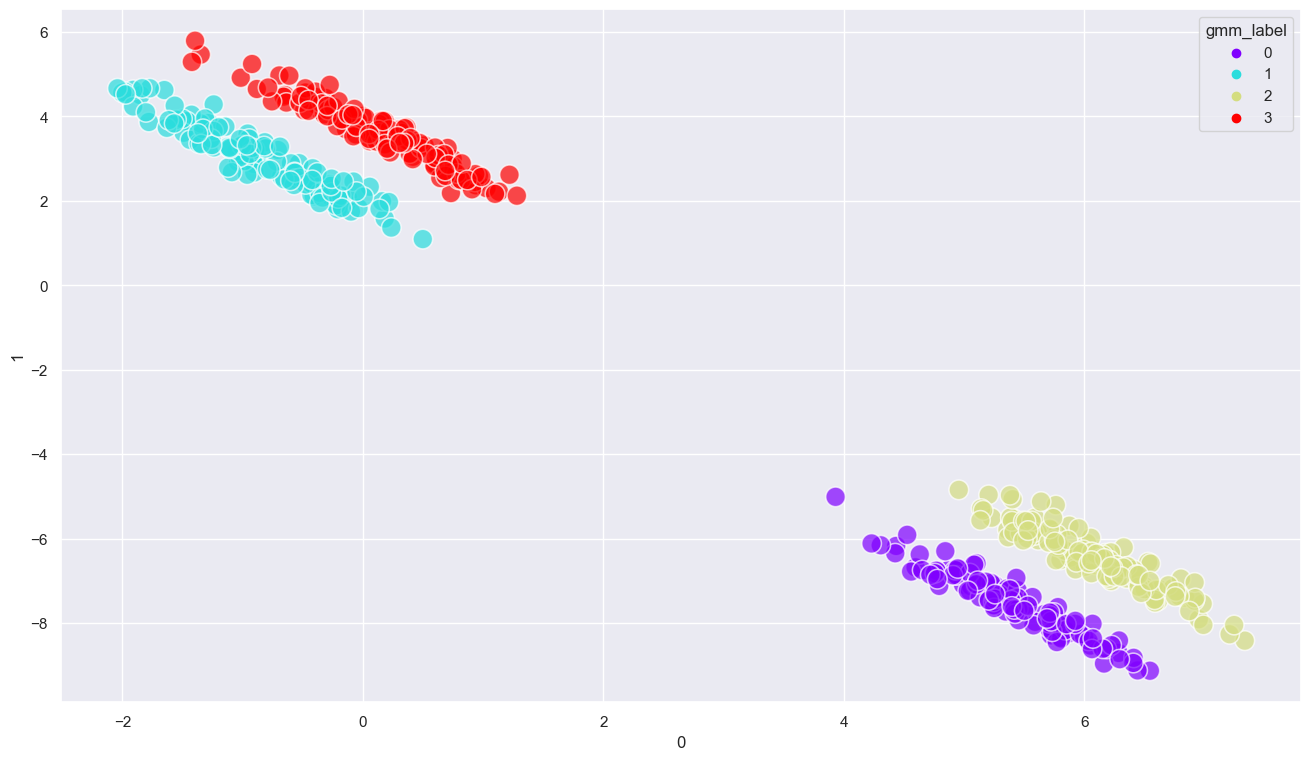

In [57]:
from sklearn.mixture import GaussianMixture

n_components = 4    # 분포 개수
random_state = 10   # 모델 고정

model = GaussianMixture(n_components=n_components, random_state=random_state)

# GMM 모델 학습
model.fit(df)
df['gmm_label'] = model.predict(df)

# 시각화
sns.scatterplot(x=df[0], y=df[1],  hue=df['gmm_label'], palette='rainbow', alpha=0.7, s=200)

NameError: name 'pca' is not defined